In [557]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,log_loss, make_scorer
from xgboost import XGBClassifier
from skopt import BayesSearchCV

import warnings
pd.set_option("display.max_columns", 101)

# Data Import and a First Glance at the Data

In [558]:
df = pd.read_csv("train.csv")

We have 2400 rows of data

In [559]:
len(df)

2400

Let's take a look which rows have missing values

In [560]:
df.isna().sum()

title                   2
country                 0
genres                  0
language                0
writer_count           94
title_adaption          0
censor_rating          38
release_date            4
runtime                 0
dvd_release_date       69
users_votes             0
comments              426
likes                 444
overall_views         317
dislikes              444
ratings_imdb            0
ratings_tomatoes        0
ratings_metacritic      0
special_award           0
awards_win              0
awards_nomination       0
revenue_category        0
dtype: int64

I will drop the rows of those columns, that have 5% or less missing values. For the rest I will impute a dedicated placeholder value -1 to denote a missing value.

In [561]:
df_nonull = df.dropna(subset=['title', 'writer_count', 'censor_rating', 'dvd_release_date'])
df_nonull = df_nonull.fillna(-1)

All missing values have been dealt with and we are left with 2220 rows. So we have dropped 7.5% of the rows, which is within an acceptable range

In [562]:
df_nonull.isna().sum()

title                 0
country               0
genres                0
language              0
writer_count          0
title_adaption        0
censor_rating         0
release_date          0
runtime               0
dvd_release_date      0
users_votes           0
comments              0
likes                 0
overall_views         0
dislikes              0
ratings_imdb          0
ratings_tomatoes      0
ratings_metacritic    0
special_award         0
awards_win            0
awards_nomination     0
revenue_category      0
dtype: int64

In [563]:
len(df_nonull)

2220

Let's also take a look at the distribution of our target feature and whether we need to possibly address a class imbalance. Luckily for us our target is quite evenly split roundabout 55/45, so no further is needed here.

In [564]:
round(df_nonull['revenue_category'].value_counts(normalize=True)*100, 2)

High    54.55
Low     45.45
Name: revenue_category, dtype: float64

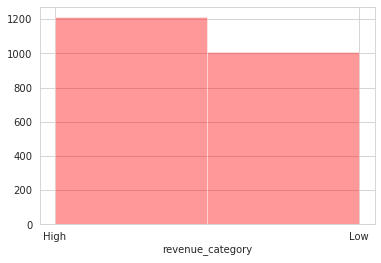

In [565]:
sns.set_style('whitegrid') 
sns.distplot(df_nonull['revenue_category'], kde = False, color ='red', bins = 2) 

# Preprocessing + Some Feature Engineering

Next up, we deconstruct the timestamp into its constituent parts, namely day of the month, weekday name, month and year. We also drop the original timestamp columns.

In [566]:
def time_decon(df, col):
    if df[col].dtype != 'datetime64[ns]':
        df[col] = pd.to_datetime(df[col])
    df[col+'_day'] = df[col].dt.day
    df[col+'_day_name'] = df[col].dt.day_name()
    df[col+'_month'] = df[col].dt.month
    df[col+'_year'] = df[col].dt.year
    return df

In [567]:
df_time = time_decon(df_nonull, 'release_date')
df_time = time_decon(df_time, 'dvd_release_date')

In [568]:
df_time = df_time.drop(['release_date', 'dvd_release_date'], axis=1)

In [569]:
df_time.head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category,release_date_day,release_date_day_name,release_date_month,release_date_year,dvd_release_date_day,dvd_release_date_day_name,dvd_release_date_month,dvd_release_date_year
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3.0,True,G,68 min,"5,654",-1.0,-1.0,-1.0,-1.0,6.4/10,80%,64/100,0,0,1,High,11,Friday,2,2005,24,Tuesday,5,2005
1,Yeh Jawaani Hai Deewani,India,"Comedy, Drama, Musical, Romance","Hindi, English, French",2.0,True,Not Rated,160 min,"33,860",9.0,124.0,127528.0,12.0,7.1/10,67%,0,0,22,92,Low,31,Friday,5,2013,15,Monday,7,2013
2,Tae Guk Gi: The Brotherhood of War,South Korea,"Action, Drama, War",Korean,4.0,False,R,140 min,"35,697",268.0,614.0,351123.0,18.0,8.1/10,80%,64/100,0,12,7,Low,24,Friday,9,2004,15,Tuesday,2,2005
3,"Book of Eli, The",USA,"Action, Adventure, Drama, Thriller",English,1.0,False,R,118 min,"2,71,524",-1.0,-1.0,-1.0,-1.0,6.9/10,47%,53/100,0,3,16,High,15,Friday,1,2010,15,Tuesday,6,2010
4,Blind Dating,USA,"Comedy, Romance",English,1.0,False,PG-13,95 min,"11,251",116.0,693.0,970306.0,36.0,6.1/10,25%,0,0,0,0,Low,26,Thursday,4,2007,5,Tuesday,2,2008


The genre, language and country columns may sometimes contain more than one value, which is then separated by a comma. I think, it's a good idea to split these several values into seperate columns so that each value has its own column.

In [570]:
genredf = df_time['genres'].str.split(', ', expand=True)
langdf = df_time['language'].str.split(', ', expand=True)
countrydf = df_time['country'].str.split(', ', expand=True)

We are able to see, that a very few number of films actually have high number of categorical values. So for the sake of dimensionality, let's give each category genre, language and country 3 seperate columns as accounting for every category with an own column, when most of the values will be NaN anyway, will probably not improve the predictive power of the model much and just add unnecessary complexity and training time.

In [571]:
for df in [genredf, langdf, countrydf]:
    print(df.isna().sum())

0       0
1     274
2     906
3    1615
4    2012
5    2161
6    2205
7    2217
dtype: int64
0       0
1    1359
2    1871
3    2078
4    2152
5    2195
6    2206
7    2212
8    2215
9    2219
dtype: int64
0        0
1     1361
2     1857
3     2079
4     2159
5     2200
6     2211
7     2212
8     2216
9     2218
10    2218
11    2218
12    2218
13    2218
14    2219
15    2219
16    2219
17    2219
18    2219
dtype: int64


In [572]:
genredf.rename(columns={0:'genre_1', 1:'genre_2', 2:'genre_3'}, inplace=True)
genredf = genredf[['genre_1', 'genre_2', 'genre_3']]

langdf.rename(columns={0:'lang_1', 1:'lang_2', 2:'lang_3'}, inplace=True)
langdf = langdf[['lang_1', 'lang_2', 'lang_3']]

countrydf.rename(columns={0:'cnt_1', 1:'cnt_2', 2:'cnt_3'}, inplace=True)
countrydf = countrydf[['cnt_1', 'cnt_2', 'cnt_3']]

In [573]:
df_cats = pd.concat([df_time, genredf, langdf, countrydf], axis=1)

In [574]:
df_cats = df_cats.drop(['genres', 'language', 'country'], axis=1)

In [575]:
df_cats = df_cats.fillna('None')

Next we have some numeric variables that are represented as strings, so let's clean them and convert as float datatype.

In [576]:
df_num = df_cats

df_num['users_votes'] = df_num['users_votes'].str.replace(r',', '').astype(float)
df_num['runtime'] = df_num['runtime'].str.replace(r' min', '').astype(float)
df_num['ratings_tomatoes'] = df_num['ratings_tomatoes'].str.replace(r'%', '').astype(float)
df_num['ratings_metacritic'] = df_num['ratings_metacritic'].str.split('/').str[0].astype(float)
df_num['ratings_imdb'] = df_num['ratings_imdb'].str.split('/').str[0].astype(float)

In [577]:
df_num.head()

,title,writer_count,title_adaption,censor_rating,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category,release_date_day,release_date_day_name,release_date_month,release_date_year,dvd_release_date_day,dvd_release_date_day_name,dvd_release_date_month,dvd_release_date_year,genre_1,genre_2,genre_3,lang_1,lang_2,lang_3,cnt_1,cnt_2,cnt_3
0,Pooh's Heffalump Movie,3.0,True,G,68.0,5654.0,-1.0,-1.0,-1.0,-1.0,6.4,80.0,64.0,0,0,1,High,11,Friday,2,2005,24,Tuesday,5,2005,Animation,Comedy,Family,English,None,None,USA,None,None
1,Yeh Jawaani Hai Deewani,2.0,True,Not Rated,160.0,33860.0,9.0,124.0,127528.0,12.0,7.1,67.0,0.0,0,22,92,Low,31,Friday,5,2013,15,Monday,7,2013,Comedy,Drama,Musical,Hindi,English,French,India,None,None
2,Tae Guk Gi: The Brotherhood of War,4.0,False,R,140.0,35697.0,268.0,614.0,351123.0,18.0,8.1,80.0,64.0,0,12,7,Low,24,Friday,9,2004,15,Tuesday,2,2005,Action,Drama,War,Korean,None,None,South Korea,None,None
3,"Book of Eli, The",1.0,False,R,118.0,271524.0,-1.0,-1.0,-1.0,-1.0,6.9,47.0,53.0,0,3,16,High,15,Friday,1,2010,15,Tuesday,6,2010,Action,Adventure,Drama,English,None,None,USA,None,None
4,Blind Dating,1.0,False,PG-13,95.0,11251.0,116.0,693.0,970306.0,36.0,6.1,25.0,0.0,0,0,0,Low,26,Thursday,4,2007,5,Tuesday,2,2008,Comedy,Romance,None,English,None,None,USA,None,None


# Outlier Detection and Removal

Outliers are a tricky topic, because oftentimes a statistical outlier might not be an outlier from a business perspective and vice versa. Outliers can often be valid, uncorrupted data, which simply represents an edge case for a business. Still, outliers can have a negative impact on a model performance, so I have chosen to remove a conservative amount using an algorithmic approach.

Please note that Isolation Forest is unsupervised, so applying it on the whole data set will not result in data leakage!

In [578]:
def isolation_outlier(df, cols=None):
    original_len = len(df)
    print('dataset with outliers:', original_len)
    isof = IsolationForest(max_samples=1000, contamination=.02)
    if cols == None:
        isof.fit(df.select_dtypes(include=np.number))
        listpred = isof.predict(df.select_dtypes(include=np.number))
    else:
        isof.fit(df[cols])
        listpred = isof.predict(df[cols])
    df['outlier'] = listpred
    df = df.loc[df['outlier'] == 1]
    df.drop('outlier', axis=1, inplace=True)
    new_len = len(df)
    diff = original_len-new_len
    print('dataset without outliers:', new_len)
    print('percentage of data removed:', round((diff/original_len)*100, 2),'%' )
    return df

In [579]:
df_num.describe()

,writer_count,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,release_date_day,release_date_month,release_date_year,dvd_release_date_day,dvd_release_date_month,dvd_release_date_year
count,2220.000000,2220.000000,2.220000e+03,2220.000000,2220.000000,2.220000e+03,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000
mean,2.609009,106.370270,8.891338e+04,467.502703,2642.376577,1.219759e+06,193.773874,6.467432,55.636937,53.577027,0.193694,6.845045,13.322072,16.094144,6.649099,2008.243694,15.850000,6.338739,2008.555405
std,2.028928,20.747366,1.527421e+05,1972.903775,9601.666650,3.894912e+06,873.259293,0.988564,27.861301,20.369788,0.395281,16.617244,25.720731,8.727442,3.460304,6.349061,8.565814,3.591668,4.129505
min,1.000000,38.000000,1.430000e+02,-1.000000,-1.000000,-1.000000e+00,-1.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1969.000000,1.000000,1.000000,1986.000000
25%,1.000000,93.750000,8.950750e+03,1.000000,22.000000,3.295325e+04,2.000000,5.900000,33.000000,41.000000,0.000000,0.000000,1.000000,9.000000,4.000000,2005.000000,8.000000,3.000000,2005.000000
50%,2.000000,103.000000,3.379150e+04,32.000000,239.000000,2.102620e+05,18.000000,6.600000,59.000000,55.000000,0.000000,2.000000,5.000000,16.000000,7.000000,2009.000000,16.000000,6.000000,2009.000000
75%,3.000000,115.000000,9.931125e+04,222.000000,1314.500000,8.718552e+05,91.000000,7.200000,80.000000,68.000000,0.000000,6.000000,13.000000,24.000000,10.000000,2012.000000,23.000000,10.000000,2012.000000
max,28.000000,566.000000,2.070977e+06,44644.000000,188526.000000,1.071502e+08,29267.000000,9.000000,100.000000,100.000000,1.000000,235.000000,326.000000,31.000000,12.000000,2068.000000,31.000000,12.000000,2017.000000


Based on the numeric columns, we have removed 2% of our data as outliers.

In [580]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    df_out = isolation_outlier(df_num)

dataset with outliers: 2220
dataset without outliers: 2175
percentage of data removed: 2.03 %


In [581]:
df_out.describe()

,writer_count,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,release_date_day,release_date_month,release_date_year,dvd_release_date_day,dvd_release_date_month,dvd_release_date_year
count,2175.000000,2175.000000,2.175000e+03,2175.000000,2175.000000,2.175000e+03,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000
mean,2.589885,105.960460,8.103232e+04,317.018851,1845.582069,9.097943e+05,132.988966,6.451586,55.299310,53.419310,0.181149,5.884138,11.958161,16.067126,6.644598,2008.102529,15.892874,6.334713,2008.500690
std,2.017652,20.419301,1.281395e+05,954.947820,5242.575252,1.961221e+06,398.496351,0.980540,27.773514,20.134707,0.385231,12.341410,21.540501,8.711892,3.452415,6.070202,8.576192,3.586898,4.086898
min,1.000000,38.000000,1.430000e+02,-1.000000,-1.000000,-1.000000e+00,-1.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1969.000000,1.000000,1.000000,1997.000000
25%,1.000000,93.000000,8.816500e+03,1.000000,20.000000,3.183250e+04,1.000000,5.900000,33.000000,41.000000,0.000000,0.000000,1.000000,9.000000,4.000000,2005.000000,9.000000,3.000000,2005.000000
50%,2.000000,103.000000,3.285700e+04,30.000000,225.000000,2.005690e+05,17.000000,6.500000,59.000000,55.000000,0.000000,2.000000,5.000000,16.000000,7.000000,2008.000000,16.000000,6.000000,2009.000000
75%,3.000000,115.000000,9.539350e+04,206.000000,1224.000000,8.029555e+05,85.500000,7.100000,80.000000,68.000000,0.000000,6.000000,13.000000,24.000000,10.000000,2012.000000,23.000000,10.000000,2012.000000
max,28.000000,566.000000,1.611302e+06,15100.000000,66518.000000,2.143433e+07,7187.000000,8.800000,100.000000,100.000000,1.000000,138.000000,242.000000,31.000000,12.000000,2067.000000,31.000000,12.000000,2017.000000


Let's quickly convert our target feature from a string into a binary integer

In [582]:
df_out['revenue_category'] = df_out['revenue_category'].map({'High': 1, 'Low': 0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Theoretically, we could also use the movie title as a predictor feature by embedding it into a vector space. I have decided against this, because of the time limit this coding test has and because we are dealing with a relatively low amount of data from several countries, making the creation of a meaningful vocabulary on which to embed on unlikely.

Therefore we drop the title column.

In [583]:
df_out = df_out.drop('title', axis=1)

# Train Test Split

We then split our data into train and test datasets.

I have decided to use the information of our target feature in a useful by stratifying the split along its distribution. This of course assumes that the original dataset is a good enough approximation of reality. If this were not the case, we would not stratify.

In [584]:
X_train, X_test, y_train, y_test = train_test_split(df_out.drop('revenue_category', axis=1), 
                                                    df_out['revenue_category'], 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=df_out['revenue_category'])



df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

As we can see, the distribution of our target feature is similar in both sets, indicating a successful split.

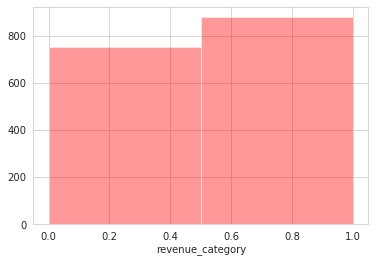

In [585]:
sns.set_style('whitegrid') 
sns.distplot(df_train['revenue_category'], kde = False, color ='red', bins = 2) 

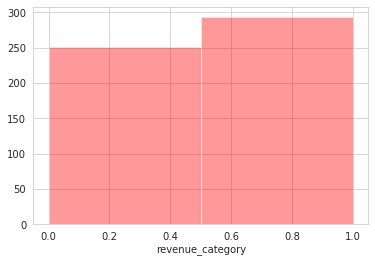

In [586]:
sns.set_style('whitegrid') 
sns.distplot(df_test['revenue_category'], kde = False, color ='red', bins = 2) 

# Categorical Features

Moving on to the transformation of categorical variables, we first identify the columns in need of preprocessing. 

Sure, variables such as day of month and month are actually ordinal cyclical ones, but keeping them as is will not take into account their cyclical properties. What you could possibly do is use a trigonometric approach by doing something like this:

x_month = sin(2*pi*month/12)
y_month = cos(2*pi*month/12)

But since I am not planning to use a linear regression model, just designating them as categorical variables is just fine.

The other columns are pretty self explanatory as they are strings, which need to be transformed into a numeric representation.

In [587]:
release_date_cols = ['release_date_year', 'release_date_month', 'release_date_day',
                     'dvd_release_date_year', 'dvd_release_date_month', 
                     'dvd_release_date_day']

cat_cols = list(X_train.select_dtypes(exclude=np.number).columns)

In [588]:
loo_cols = cat_cols + release_date_cols

To deal with categorical, I employ a "leave one out" target encoder.

The encoded column will not result conventional dummy variable, but instead is the mean response over all rows for this categorical level, excluding the row itself. This gives you the advantage of having a one-column representation of the categorical while avoiding direct response leakage.

Given that some of the categorical columns are high dimensional, encoding them as Dummy or One Hot features would drastically increase our dataset's dimensionality, so enconding into one column without data leakage is highly preferable for the sake of training time optimization as well as model complexity.

Training the encoder is performed exclusively on the training data.

In [589]:
loo = LeaveOneOutEncoder(cols = loo_cols, drop_invariant=True, handle_unknown='value')
loo.fit(X_train, y_train)

LeaveOneOutEncoder(cols=['title_adaption', 'censor_rating',
                         'release_date_day_name', 'dvd_release_date_day_name',
                         'genre_1', 'genre_2', 'genre_3', 'lang_1', 'lang_2',
                         'lang_3', 'cnt_1', 'cnt_2', 'cnt_3',
                         'release_date_year', 'release_date_month',
                         'release_date_day', 'dvd_release_date_year',
                         'dvd_release_date_month', 'dvd_release_date_day'],
                   drop_invariant=True, handle_missing='value',
                   handle_unknown='value', random_state=None, return_df=True,
                   sigma=None, verbose=0)

You will notice that the test data is encoded based on the insights derived from the training on the training data, thus no data leakage occurs!

In [590]:
X_train = loo.transform(X_train)
X_test = loo.transform(X_test)

# Baseline: Using the Majority Class Value of the Training Dataset as our Prediction

We are done with data preprocessing. Next, we will create a naive baseline using the Majority Class Value of the train set target as our sole prediction value and see how we fare.

In [591]:
y_pred_maj = np.tile(1, len(y_test))

Our Accuracy in this case is 54% and this is the number we have to beat in order for our model to be viable.

In [592]:
baseline_acc = accuracy_score(y_test, y_pred_maj)
round(baseline_acc*100,2)

53.86

# Hyperparameter Optimization, K-Fold cross validation and Model Training

As for the algorithm, I choose XGBoost because it is non-parametric, handles different data types well and is very robust against abnormalities in the data. In industrial application, it often performs well out of the box. 

In [593]:
acc_scorer = make_scorer(accuracy_score, greater_is_better=True)

After establishing a baseline, we now define a parameter space for an XGBoost Classification algorithm.

We then create an instance for Bayesian Hyperparameter Optimization and K-Fold Cross Validation and begin fitting the folds. Due to the relatively low amount of data, we should exceed 5 folds.

In [594]:
params_xgb = {"n_estimators": [10,20,50,100],
              "max_depth": list(range(1, 11)),
              "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.],
              "subsample": list(np.arange(0.05, 1.01, 0.05)),
              "min_child_weight": list(range(1, 21)),
              "colsample_bytree": list(np.arange(0.1,1,0.1)),
              "reg_lambda": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
              "reg_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]

              }
xgb = XGBClassifier(n_jobs=-1)
bcvxg = BayesSearchCV(xgb, params_xgb,cv=5, n_iter=100, random_state=42, verbose=1, n_jobs=-1, n_points=100, 
                      scoring=acc_scorer)

In [595]:
with warnings.catch_warnings():
    #The Bayes Optimizer Library throws some pretty lenghty FutureWarnings during fitting. We will ignore them.
    warnings.filterwarnings("ignore")
    bcvxg.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 369 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed:   29.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.3s finished


The average accuracy over all 5 folds of our best classifier is 88.5%. Much better than our baseline. 

In [596]:
round(bcvxg.best_score_*100,2)

88.47

# Prediction and Result on Test Split

After fitting the folds, we create a variable for the algorithm with the settings that yielded the highest accuracy and train on the entire data with these parameters.

In [597]:
best = bcvxg.best_estimator_
best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.0001,
              reg_lambda=10.0, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

After having performed Hyperparameter Optimization and K-Fold Cross Validation, we take the algorithm with the best parameters and train it with the entire training data and let it predict on test data set.

On unseen data, the model performs similarly at an accuracy of 89.9%, which is even slightly better than our Cross Validation mean accuracy and indicates that the model generalizes well. 

In [598]:
acc_xg = accuracy_score(y_test, best.predict(X_test))
print('accuracy xgboost:', round(acc_xg*100, 2))

accuracy xgboost: 89.89


# Validation Dataset and CSV File Submission

Let us import the validation data on which this task will be evaluated and give it a quick check.

In [616]:
val = pd.read_csv('test.csv')

In [617]:
val.head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination
0,Delhi-6,India,"Comedy, Drama","Hindi, English",3.0,True,Not Rated,20-Feb-09,141 min,16-Jun-09,"6,337",7.0,43.0,165008.0,13.0,6.0/10,40%,45/100,0,2,7
1,Before I Disappear,"USA, UK",Drama,English,1.0,False,Unrated,28-Nov-14,93 min,19-May-15,"8,370",NaN,NaN,NaN,NaN,7.2/10,38%,47/100,0,16,8
2,"Good Year, A","USA, UK","Comedy, Drama, Romance","English, French, Russian",2.0,True,PG-13,10-Nov-06,117 min,27-Feb-07,"82,062",14.0,276.0,187788.0,17.0,7.0/10,25%,47/100,0,1,2
3,Brüno,"USA, UK",Comedy,"English, German",9.0,True,R,10-Jul-09,81 min,17-Nov-09,"1,33,925",81.0,301.0,200324.0,43.0,5.8/10,67%,54/100,0,2,5
4,How to Lose a Guy in 10 Days,"USA, Germany","Comedy, Romance",English,5.0,True,PG-13,07-Feb-03,116 min,01-Jul-03,"1,90,396",74.0,480.0,740345.0,23.0,6.4/10,42%,45/100,0,1,8


We are not using the title for prediction purposes but later need it for our csv file, so let's store it seperately.

In [618]:
val_title = val['title'].values

Let us also check the number of rows and the missing values.

In [619]:
len(val)

600

Unlike on our training data, I will refrain from dropping columns for the sake predicting on complete data. Therefore I will simply impute the missing values with -1.

In [620]:
val.isna().sum()

title                   0
country                 0
genres                  0
language                0
writer_count           29
title_adaption          0
censor_rating          16
release_date            2
runtime                 0
dvd_release_date       18
users_votes             0
comments              124
likes                 123
overall_views          93
dislikes              123
ratings_imdb            0
ratings_tomatoes        0
ratings_metacritic      0
special_award           0
awards_win              0
awards_nomination       0
dtype: int64

In [621]:
val = val.fillna(-1)

We perform the same preprocessing here as we did on our training data, so that the algorithm can work with the inputs and is able to perform prediction.

In [622]:
val = time_decon(val, 'release_date')
val = time_decon(val, 'dvd_release_date')
val = val.drop(['release_date', 'dvd_release_date', 'title'], axis=1)

In [623]:
val_genredf = val['genres'].str.split(', ', expand=True)
val_langdf = val['language'].str.split(', ', expand=True)
val_countrydf = val['country'].str.split(', ', expand=True)

In [624]:
val_genredf.rename(columns={0:'genre_1', 1:'genre_2', 2:'genre_3'}, inplace=True)
val_genredf = val_genredf[['genre_1', 'genre_2', 'genre_3']]

val_langdf.rename(columns={0:'lang_1', 1:'lang_2', 2:'lang_3'}, inplace=True)
val_langdf = val_langdf[['lang_1', 'lang_2', 'lang_3']]

val_countrydf.rename(columns={0:'cnt_1', 1:'cnt_2', 2:'cnt_3'}, inplace=True)
val_countrydf = val_countrydf[['cnt_1', 'cnt_2', 'cnt_3']]

In [625]:
val = val.fillna('None')

In [626]:
val = pd.concat([val, val_genredf, val_langdf, val_countrydf], axis=1)
val = val.drop(['genres', 'language', 'country'], axis=1)

In [627]:
val['users_votes'] = val['users_votes'].str.replace(r',', '').astype(float)
val['runtime'] = val['runtime'].str.replace(r' min', '').astype(float)
val['ratings_tomatoes'] = val['ratings_tomatoes'].str.replace(r'%', '').astype(float)
val['ratings_metacritic'] = val['ratings_metacritic'].str.split('/').str[0].astype(float)
val['ratings_imdb'] = val['ratings_imdb'].str.split('/').str[0].astype(float)

In [628]:
val_trans = loo.transform(val)

After a final check, the data looks good and we can use our pre-trained model to predict. The predictions and CSV make sense, too! 

In [629]:
val_trans.head()

,writer_count,title_adaption,censor_rating,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,release_date_day,release_date_day_name,release_date_month,release_date_year,dvd_release_date_day,dvd_release_date_day_name,dvd_release_date_month,dvd_release_date_year,genre_1,genre_2,genre_3,lang_1,lang_2,lang_3,cnt_1,cnt_2,cnt_3
0,3.0,0.600470,0.006849,141.0,6337.0,7.0,43.0,165008.0,13.0,6.0,40.0,45.0,0,2,7,0.535714,0.616372,0.618182,0.561404,0.680851,0.553417,0.633028,0.596330,0.550218,0.446712,0.538320,0.038462,0.142857,0.53832,0.038462,0.538320,0.53832
1,1.0,0.470513,0.000000,93.0,8370.0,-1.0,-1.0,-1.0,-1.0,7.2,38.0,47.0,0,16,8,0.560000,0.616372,0.571429,0.419355,0.392857,0.553417,0.575540,0.440678,0.347258,0.538320,0.538320,0.611310,0.538320,0.53832,0.665142,0.597826,0.53832
2,2.0,0.600470,0.747554,117.0,82062.0,14.0,276.0,187788.0,17.0,7.0,25.0,47.0,0,1,2,0.562500,0.616372,0.571429,0.675439,0.649123,0.553417,0.494118,0.650943,0.550218,0.446712,0.535714,0.611310,0.500000,0.75000,0.665142,0.597826,0.53832
3,9.0,0.600470,0.464435,81.0,133925.0,81.0,301.0,200324.0,43.0,5.8,67.0,54.0,0,2,5,0.562500,0.616372,0.541667,0.561404,0.530303,0.553417,0.517483,0.596330,0.550218,0.538320,0.538320,0.611310,0.543478,0.53832,0.665142,0.597826,0.53832
4,5.0,0.600470,0.747554,116.0,190396.0,74.0,480.0,740345.0,23.0,6.4,42.0,45.0,0,1,8,0.500000,0.616372,0.618182,0.645570,0.521739,0.553417,0.439655,0.600000,0.550218,0.452703,0.538320,0.611310,0.538320,0.53832,0.665142,0.645455,0.53832


In [630]:
val_trans['predictions'] = best.predict(val_trans)
val_trans['title'] = val_title

In [631]:
submissions = val_trans[['title', 'predictions']]

In [632]:
submissions.head(10)

,title,predictions
0,Delhi-6,0
1,Before I Disappear,0
2,"Good Year, A",1
3,Brüno,1
4,How to Lose a Guy in 10 Days,1
5,Restless,0
6,Young & Beautiful,0
7,Iron Man 3,1
8,Invictus,1
9,"SpongeBob SquarePants Movie, The",1


In [633]:
submissions.to_csv('submissions.csv', index=False)

# That's it (: